In [1]:
import gym
from gym import spaces
from gym import utils
from gym.utils import seeding
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm import tqdm
from numpy import linalg as LA
from copy import deepcopy

# import logging
# logger = logging.getLogger(__name__)

C:\Users\wuc3\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
n=5  # max items to store in the warehouse
gas=0.2     # gas fee for one trip
c=3     # single item cost
h=1.8    # storage fee for one item, if it was not sold during the day. 
p=7    # retail price for one item
x0= random.randint(0,n)
gamma = 0.9999 # Discount factor, the future values matters
alpha = 0.1 # Learning rate 
# epsilon=0.1
stage=10
Q = np.array(np.zeros([n+1,n+1]))
action=random.randint(0,n-x0)
oldQ=np.array(np.zeros([n+1,n+1]))
# sum_rwd=0

In [3]:
class Policy_opt():   # optimal policy for quick change detection
  

    def __init__(self, n, gas, c, h, p, x0, lamda, Q, gamma, alpha, stage):
        self.n = n
        self.state = x0
        self.gas = gas         # fixed entry cost K when ordering nonezero items
        self.c = c             # each item must be purchased with a fixed price c
        self.h = h             # cost h, when holding an item
        self.p = p             # get paid p, when selling an item
        self.lamda = lamda
        self.Q = Q
        self.gamma=gamma
        self.alpha=alpha
        self.stage=stage


        # Set seed
        self._seed()


    def demand1(self):
        return np.random.poisson(self.lamda)   # poisson distribution 
   
    def demand2(self):
        return np.random.randint(0,self.n+1)  #  “discrete uniform” distribution [0,n]
    
    def transition(self, x, a, d):   # the inventory of day (t+1)
        return max(min(x + a, n) - d, 0)

    def reward(self, x, a, y):
        r = -self.gas * (a > 0) - self.c * a - self.h * x + self.p * (x+a-y)  
        # we have checked the action, will not order more than we can store
        return r

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, state, action,demand):    
#         assert self.action_space.contains(action)
        obs = state
        obs2 = self.transition(obs, action, demand)  # next day inventory
        self.state = obs2
        reward = self.reward(obs, action, obs2)
#         done = 0
        return obs2, reward


    def offpolicy(self):
        prob0 = []   # the pmf of demand for MDP0
        for k in range(0, self.n):
            prob0.append(poisson.pmf(k, self.lamda))  # the pmf of demand=k, for MDP0, the truncated pmf  
        prob0.append(1-poisson.cdf(self.n-1, self.lamda))    # append the probability(demand>=s+a) and s'=0
        
        J0 = np.array(np.zeros([n+1,n+1]))      # for poisson, calculate the one step J=E{g[s,a]}
        draft_J0 = np.array(np.zeros([n+1,n+1])) 
        g0= np.array(np.zeros([n+1,n+1])) 
        for stat in range(self.n+1):  #this finishes one stage of updating J
            for action in range(self.n-stat+1):
                for demand in range(self.n+1):
                    [next_stat, reward]=self._step(stat, action,demand)
                    g0[stat, action]+=reward*prob0[demand]  
#                   g0[stat,action] =E(g(X, u, w))
        
        for t in range(self.stage):   
            for stat in range(self.n+1):  #this finishes one stage of updating J
                for action in range(self.n-stat+1):
                    for demand in range(self.n+1):
                        [next_stat, reward]=self._step(stat, action,demand)
                        draft_J0[stat,action]=g0[stat,action] + max(J0[next_stat])  * prob0[demand]
#                       g0[stat,action] =E(g(X_k-1, u_k-1, w_k-1))
#                       max(J0[next_stat]) *prob0[demand]= max E(J0_k)
            J0=draft_J0
        
                
        prob1=[]   #uniform distribution
        for i in range(self.n+1):
            prob1.append(1/6)
            
        J1 = np.array(np.zeros([n+1,n+1])) 
        draft_J1 = np.array(np.zeros([n+1,n+1]))
        g1= np.array(np.zeros([n+1,n+1])) 
        for stat in range(self.n+1):  #this finishes one stage of updating J
            for action in range(self.n-stat+1):
                for demand in range(self.n+1):
                    [next_stat, reward]=self._step(stat, action,demand)
                    g1[stat, action]+=reward*prob1[demand] 
                    
        for t in range(self.stage):   
            for stat in range(self.n+1):
                for action in range(self.n-stat+1):
                    for demand in range(self.n+1):
                        [next_stat, reward]=self._step(stat, action,demand)
                        draft_J1[stat,action]=g1[stat,action] + max(J1[next_stat])  * prob1[demand]
#                       g1[stat,action] =E(g(X_k-1, u_k-1, w_k-1))
#                       max(J1[next_stat]) *prob1[demand]= max E(J1_k)
            J1=draft_J1
                          
        return J0, J1
        


Text(0.5, 1.0, 'optimal policy of poisson (lamda=2.000000) and uniform')

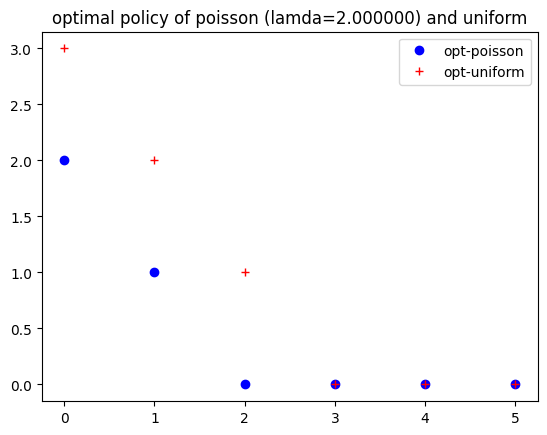

In [5]:
# E = np.array(np.zeros([n+1,n+1]))
lamda=2
policy= Policy_opt(n, gas, c, h, p, x0, lamda, Q, gamma, alpha,stage)


A=policy.offpolicy()[0]
for action in range(1,n+1):
    A[action,n-action+1:]=-np.inf

opt_po1=np.argmax(A, axis=1)
plt.plot(np.argmax(A, axis=1),'bo', label='opt-poisson') #ideal case
# plt.plot(qcd_policy,'.', label='qcd policy')
opt_uni=np.argmax(policy.offpolicy()[1], axis=1)
plt.plot(opt_uni,'r+',label='opt-uniform') # simulation
plt.legend(loc='upper right')
plt.title(f'optimal policy of poisson (lamda=%f) and uniform' %lamda)

Text(0.5, 1.0, 'optimal policy of poisson (lamda=2.200000) and uniform')

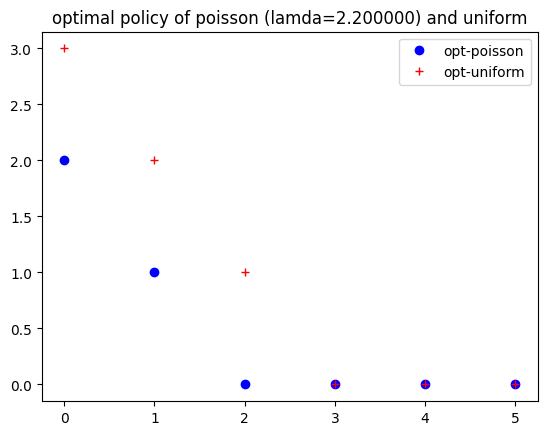

In [6]:
# E = np.array(np.zeros([n+1,n+1]))
lamda=2.2
policy= Policy_opt(n, gas, c, h, p, x0, lamda, Q, gamma, alpha,stage)


A=policy.offpolicy()[0]
for action in range(1,n+1):
    A[action,n-action+1:]=-np.inf

opt_po1=np.argmax(A, axis=1)
plt.plot(np.argmax(A, axis=1),'bo', label='opt-poisson') #ideal case
# plt.plot(qcd_policy,'.', label='qcd policy')
opt_uni=np.argmax(policy.offpolicy()[1], axis=1)
plt.plot(opt_uni,'r+',label='opt-uniform') # simulation
plt.legend(loc='upper right')
plt.title(f'optimal policy of poisson (lamda=%f) and uniform' %lamda)

Text(0.5, 1.0, 'optimal policy of poisson (lamda=4.000000) and uniform')

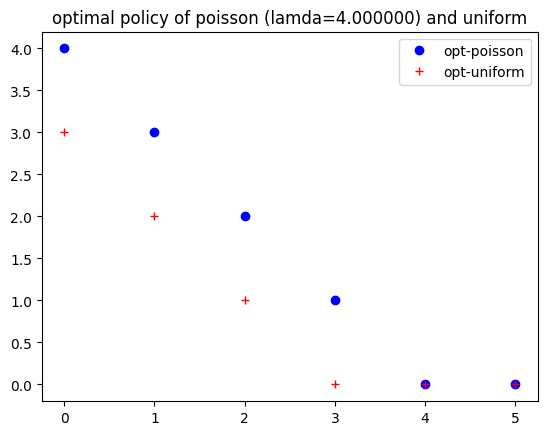

In [7]:
lamda=4
policy= Policy_opt(n, gas, c, h, p, x0, lamda, Q, gamma, alpha,stage)

A=policy.offpolicy()[0]
for action in range(1,n+1):
    A[action,n-action+1:]=-np.inf
    
opt_po2=np.argmax(A, axis=1)
plt.plot(np.argmax(A, axis=1),'bo', label='opt-poisson') #ideal case
plt.plot(np.argmax(policy.offpolicy()[1], axis=1),'r+',label='opt-uniform' ) # simulation
plt.legend(loc='upper right')
plt.title(f'optimal policy of poisson (lamda=%f) and uniform' %lamda)


Text(0.5, 1.0, 'optimal policy of poisson (lamda=2.800000) and uniform')

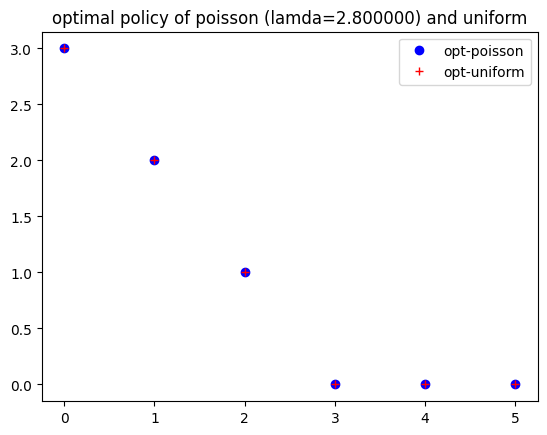

In [8]:
lamda=2.8
policy= Policy_opt(n, gas, c, h, p, x0, lamda, Q, gamma, alpha, stage)

A=policy.offpolicy()[0]
for action in range(1,n+1):
    A[action,n-action+1:]=-np.inf
    
opt_po3=np.argmax(A, axis=1)
plt.plot(np.argmax(A, axis=1),'bo', label='opt-poisson') #ideal case
plt.plot(np.argmax(policy.offpolicy()[1], axis=1),'r+',label='opt-uniform' ) # simulation
plt.legend(loc='upper right')
plt.title(f'optimal policy of poisson (lamda=%f) and uniform' %lamda)


Text(0.5, 1.0, 'optimal policy of poisson (lamda=3.600000) and uniform')

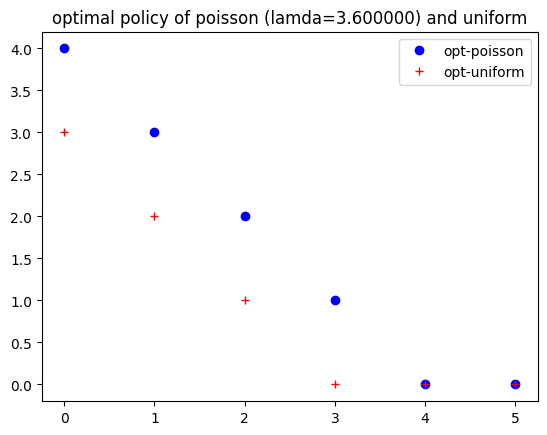

In [12]:
lamda=3.6
policy= Policy_opt(n, gas, c, h, p, x0, lamda, Q, gamma, alpha,stage)

A=policy.offpolicy()[0]
for action in range(1,n+1):
    A[action,n-action+1:]=-np.inf
opt_po4=np.argmax(A, axis=1)
opt_uniform= np.argmax(policy.offpolicy()[1], axis=1)
plt.plot(np.argmax(A, axis=1),'bo', label='opt-poisson') #ideal case
plt.plot(np.argmax(policy.offpolicy()[1], axis=1),'r+',label='opt-uniform' ) # simulation
plt.legend(loc='upper right')
plt.title(f'optimal policy of poisson (lamda=%f) and uniform' %lamda)

Text(0.5, 1.0, 'optimal policies under different distributions')

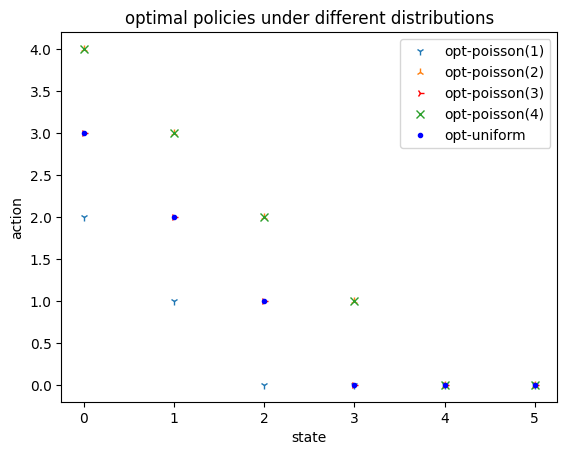

In [13]:

plt.plot(opt_po1,'1', label='opt-poisson(1)') #ideal case
plt.plot(opt_po2,'2', label='opt-poisson(2)') #ideal case
plt.plot(opt_po3,'r4', label='opt-poisson(3)') #ideal case
plt.plot(opt_po4,'x', label='opt-poisson(4)') #ideal case
plt.plot(opt_uniform,'b.',label='opt-uniform') # ideal case

plt.xlabel('state')
plt.ylabel('action')

plt.legend(loc='upper right')
plt.title(f'optimal policies under different distributions')

Text(0.5, 1.0, 'best_qcd of poisson(lamda=3.600000) and uniform')

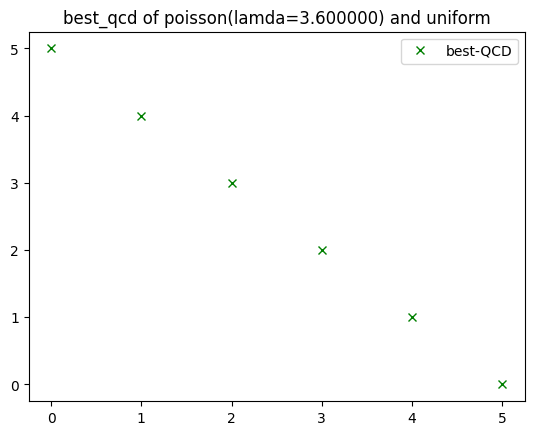

In [14]:
delta=policy.offpolicy()[0]-policy.offpolicy()[1]
plt.plot(np.argmax(abs(delta), axis=1),'gx', label='best-QCD') #id
plt.legend(loc='upper right')
plt.title(f'best_qcd of poisson(lamda=%f) and uniform' %lamda)
